# Method comparisons for inference

In [741]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import statsmodels.api as sm
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.max_columns', 100)

import pickle as pkl
import time
import string
from sklearn.datasets import make_spd_matrix
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.linear_model import LinearRegression

In [742]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver', 'yellow'])

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)


In [743]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg')
import memento
import memento.simulate as simulate

In [744]:
import matplotlib
matplotlib.rcParams['legend.handlelength'] = 0

In [745]:
data_path = '/data_volume/memento/simulation/inference/'

### Compare true vs sampled data for ttest

In [772]:
q = 0.1
def compute_moments(count_data):
    
    captured_cell_sizes = count_data.sum(axis=1)
    num_cells = count_data.shape[0]
    
    relative_data = count_data/captured_cell_sizes.reshape(-1,1)
    m_hat = relative_data.mean(axis=0)
    naive_var_hat = relative_data.var(axis=0)
    memento_var_hat = naive_var_hat-(1-q)*(count_data/(captured_cell_sizes**2-captured_cell_sizes*(1-q)).reshape(-1,1)).mean(axis=0)

    naive_se = np.sqrt(naive_var_hat/num_cells)
    memento_se = np.sqrt(memento_var_hat/num_cells)
        
    return m_hat.reshape(-1), memento_var_hat.reshape(-1)

def run_ttest_from_stats(data1, data2):
    
    m1, v1 = compute_moments(data1)
    m2, v2 = compute_moments(data2)


    cs1=data1.sum(axis=1).reshape(-1,1)
    cs2 = data2.sum(axis=1).reshape(-1,1)
    cs = np.vstack([cs1, cs2])
    x = sm.add_constant(np.hstack([np.zeros(data1.shape[0]), np.ones(data2.shape[0])]).reshape(-1,1))
    y_raw = np.vstack([data1, data2])
    y_rel = np.vstack([data1/cs1, data2/cs2])
#     v = np.ones(y.shape)

    v = y_raw*(1-q)/(cs**2)
    v[:data1.shape[0], :] += v1
    v[data1.shape[0]:, :] += v2
    
    wls_pv = [sm.WLS(y_rel[:, i], x, weights=1/v[:, i]).fit().pvalues[-1] for i in range(m1.shape[0])]
    
    return _, wls_pv

    # Log transformations and wald test
    log_m1 = np.log(m1)
    log_m2 = np.log(m2)
    log_fc = (log_m2-log_m1)/2
    se_1 = np.sqrt(v1/data1.shape[0])
    se_2 = np.sqrt(v2/data2.shape[0])
    log_se_1 = ((np.log(m1 + se_1) - np.log(m1 - se_1))/2)
    log_se_2 = ((np.log(m2 + se_2) - np.log(m2 - se_2))/2)
    
    wald_stat = (log_fc/np.sqrt(log_se_1**2 + log_se_2**2))
    
    return log_fc, stats.norm.sf(np.absolute(wald_stat))*2
    
    return stats.ttest_ind_from_stats(m1_true, np.sqrt(v1), data1.shape[0], m2_true, np.sqrt(v2), data2.shape[0])[1]

In [ ]:
de_adata = sc.read(data_path + 'means/simple/anndata_0.h5ad')
de_norm_adata = sc.read(data_path + 'means/simple/norm_anndata_0.h5ad')
de_true_norm_adata = sc.read(data_path + 'means/simple/norm_true_anndata_0.h5ad')

genes = de_adata.var.index[de_adata.X.mean(axis=0).A1 > 0.05].tolist()
de_adata = de_adata[:, genes]
de_norm_adata = de_norm_adata[:, genes]
de_true_norm_adata = de_true_norm_adata[:, genes]

result = pd.DataFrame()
result['gene'] = genes

A_data, B_data = de_norm_adata[de_norm_adata.obs['condition'] == 'ctrl'].X.toarray(), de_norm_adata[de_norm_adata.obs['condition'] == 'stim'].X.toarray()
result['null'] = de_norm_adata.var['is_null'].values
result['sig'] = ~result['null']
_, result['ttest'] = stats.ttest_ind(A_data, B_data, equal_var=True)
m1_captured, m2_captured = A_data.mean(axis=0), B_data.mean(axis=0)
result['dim_captured'] = m2_captured-m1_captured
result['lfc_captured'] = np.log(m2_captured/m1_captured)

A_data, B_data = de_true_norm_adata[de_true_norm_adata.obs['condition'] == 'ctrl'].X.toarray(), de_true_norm_adata[de_true_norm_adata.obs['condition'] == 'stim'].X.toarray()
_, result['ttest_true'] = stats.ttest_ind(A_data, B_data, equal_var=False)
m1_true, m2_true = A_data.mean(axis=0), B_data.mean(axis=0)
v1_true, v2_true = A_data.var(axis=0), B_data.var(axis=0)
result['v_fc'] = v2_true/v1_true

result['dim_true'] = m2_true-m1_true
result['lfc_true'] = np.log(m2_true/m1_true)

A_data, B_data = de_adata[de_adata.obs['condition'] == 'ctrl'].X, de_adata[de_adata.obs['condition'] == 'stim'].X
_,result['ttest_mem'] = run_ttest_from_stats(A_data.toarray(), B_data.toarray())

In [774]:
result.query('sig & ttest_true < 0.1').head(20)#[['gene', 'dim_captured', 'dim_true']]

,gene,null,sig,ttest,dim_captured,lfc_captured,ttest_true,v_fc,dim_true,lfc_true,ttest_mem
26,145,False,True,4.094644e-01,0.000064,0.301630,1.618776e-04,5.775568,0.000185,0.851666,1.927741e-01
75,292,False,True,1.686994e-11,0.001118,1.377999,1.296859e-18,6.952964,0.001012,1.197029,2.534345e-12
89,352,False,True,4.412315e-01,0.000035,0.433084,9.177322e-03,2.470355,0.000050,0.591552,4.492437e-01
103,409,False,True,1.843443e-02,0.000091,1.274394,3.862114e-03,2.018516,0.000070,0.622683,6.017526e-01
134,543,False,True,4.454346e-02,0.000067,1.256108,1.684438e-05,2.399572,0.000068,1.471605,6.032164e-01
144,574,False,True,5.228894e-01,0.000023,0.403772,1.913287e-02,1.819458,0.000053,0.697993,8.926545e-01
176,686,False,True,3.179826e-05,0.000236,1.807131,4.732347e-10,4.132748,0.000278,1.612621,1.158271e-01
305,1243,False,True,1.408790e-08,0.001099,1.471669,3.126891e-16,37.344479,0.001329,1.746248,5.061144e-12
323,1318,False,True,1.172871e-01,0.000467,0.221646,1.251606e-02,0.782491,0.000551,0.252305,1.283691e-01
594,2352,False,True,5.715699e-02,0.000164,0.576425,3.259177e-05,2.695580,0.000222,0.749408,4.515825e-01


In [775]:
result['ttest_fdr'] = memento.util._fdrcorrect(result['ttest'])
result['ttest_true_fdr'] = memento.util._fdrcorrect(result['ttest_true'])
result['ttest_mem_fdr'] = memento.util._fdrcorrect(result['ttest_mem'])


In [776]:
result.head(2)

,gene,null,sig,ttest,dim_captured,lfc_captured,ttest_true,v_fc,dim_true,lfc_true,ttest_mem,ttest_fdr,ttest_true_fdr,ttest_mem_fdr
0,1,True,False,0.833180,-0.000012,-0.106328,0.298184,0.418455,-0.000019,-0.252131,0.898897,0.981222,0.919865,0.999923
1,3,True,False,0.177055,0.000091,0.679659,0.004209,0.242618,0.000134,0.960764,0.631794,0.913977,0.301100,0.999923


In [777]:
# methods = ['memento_fdr', 'ttest_fdr','edger_fdr']
methods = ['ttest', 'ttest_true', 'ttest_mem']

In [778]:
thresholds = np.linspace(0, 0.3, 20)

tpr_pv_dict = {}
tpr_fdr_dict = {}
precision_pv_dict = {}
precision_fdr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in methods:
    tpr_pv = []
    tpr_fdr = []
    fpr = []
    fdr = []
    precision_pv = []
    precision_fdr = []

    for thresh in thresholds:
    
        tpr_pv.append((result.query('sig')[method] < thresh).mean())
        tpr_fdr.append((result.query('sig')[method+'_fdr'] < thresh).mean())
        fdr.append(result.query('{} < {}'.format(method+'_fdr', thresh))['null'].mean())
        fpr.append((result.query('null')[method] < thresh).mean())
        
    tpr_pv_dict[method] = tpr_pv
    tpr_fdr_dict[method] = tpr_fdr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

Text(0.5, 0, 'Recall')

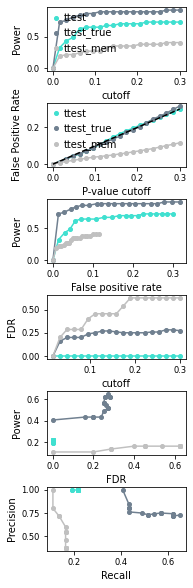

In [779]:
plt.figure(figsize=(2.5, 10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(6, 1, 1)
for method in methods:
    plt.plot(thresholds, tpr_pv_dict[method], '-o', label=method, ms=4)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('Power'); plt.xlabel('P-value cutoff')
plt.xlabel('cutoff')

plt.subplot(6, 1, 2)
for method in methods:
    plt.plot(thresholds, fpr_dict[method], '-o', label=method, ms=4)
plt.plot([0,0.3], [0, 0.3], '--', color='k')

plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('False Positive Rate'); plt.xlabel('P-value cutoff')

plt.subplot(6, 1, 3)
for method in methods:
    plt.plot(fpr_dict[method], np.array(tpr_pv_dict[method]),'-o', label=method, ms=4)
plt.ylabel('Power'); plt.xlabel('False positive rate')

plt.subplot(6, 1, 4)
for method in methods:
    plt.plot(thresholds, fdr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('FDR'); plt.xlabel('FDR cutoff')
plt.xlabel('cutoff')

plt.subplot(6, 1, 5)
for method in methods:
    plt.plot(fdr_dict[method], np.array(tpr_fdr_dict[method]),'-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('Power'); plt.xlabel('FDR')
# plt.xlabel('P-value cutoff')

plt.subplot(6, 1, 6)
for method in methods:
    plt.plot(np.array(tpr_fdr_dict[method]), 1-np.array(fdr_dict[method]),'-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('Precision'); plt.xlabel('Recall')

# plt.savefig('de_comparison.pdf', bbox_inches='tight')

In [189]:
de_sim_adata = sc.read(data_path + 'means/simple/anndata_0.h5ad')
de_sim_adata.obs['q'] = 0.1

memento.setup_memento(de_sim_adata, q_column='q', filter_mean_thresh=0.01,trim_percent=0.1, shrinkage=0)
de_sim_adata.obs['memento_size_factor'] = de_sim_adata.X.sum(axis=1).A1
memento.create_groups(de_sim_adata, label_columns=['condition'])
memento.compute_1d_moments(de_sim_adata, filter_genes=True)

meta_df = memento.get_groups(de_sim_adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=True)

treatment = meta_df[['stim']]
covariate = pd.DataFrame(np.ones((meta_df.shape[0],1)))
# covariate = meta_df[['B', 'C', 'D']]
# covariate = pd.concat([covariate, covariate*treatment.values], axis=1)

# means = memento.ht_1d_moments(
#     de_sim_adata, 
#     treatment=treatment,
#     covariate=covariate,
#     num_boot=5000, 
#     verbose=1,
#     num_cpus=14,
#     resample_rep=False,
#     approx=True)

# memento_de_result = memento.get_1d_ht_result(de_sim_adata)
# memento_de_result.to_csv(data_path + 'means/stratified/memento.csv', index=False)

In [51]:
ctrl_mean = de_sim_adata.uns['memento']['1d_moments']['sg^ctrl'][0]
stim_mean = de_sim_adata.uns['memento']['1d_moments']['sg^stim'][0]
ctrl_var = de_sim_adata.uns['memento']['1d_moments']['sg^ctrl'][1]
stim_var = de_sim_adata.uns['memento']['1d_moments']['sg^stim'][1]
ctrl_se = np.sqrt(ctrl_var/(de_sim_adata.shape[0]/2))
stim_se = np.sqrt(stim_var/(de_sim_adata.shape[0]/2))

ctrl_log_mean = np.log(ctrl_mean)
stim_log_mean = np.log(stim_mean)
ctrl_log_se = (np.log(ctrl_mean+ctrl_se)-np.log(ctrl_mean-ctrl_se))/2
stim_log_se = (np.log(stim_mean+stim_se)-np.log(stim_mean-stim_se))/2
ctrl_log_sv = ctrl_log_se**2
stim_log_sv = stim_log_se**2

approx_means = list(zip(list(zip(ctrl_log_mean, stim_log_mean)), list(zip(ctrl_log_sv, stim_log_sv))))
# approx_means = list(zip(list(zip(ctrl_mean, stim_mean)), list(zip(ctrl_se**2, stim_se**2))))

In [52]:
approx_means[0]

((-9.256156, -9.3182125), (0.0019935018, 0.002846779))

In [71]:
# datasets = [core.Dataset(y=m, v=v, X=meta_df[['stim']].values, add_intercept=True) for m,v in means]
# from pymare import estimators, core
# results = []

# for m,v in approx_means:
    
#     df = meta_df
#     df['m'] = m
#     df['v'] = v
#     dset = core.Dataset(data=df, y='m', v='v', X=['stim'])
    
#     res = estimators.WeightedLeastSquares().fit_dataset(dset).summary().to_df().set_index('name').loc['stim', ['estimate', 'p-value']]
    
#     results.append(res)
    
# memento_results = pd.DataFrame(np.vstack([results]),columns=['coef', 'de_pval'])

_, pv = stats.ttest_ind_from_stats(stim_mean, np.sqrt(ctrl_var), 1000,ctrl_mean, np.sqrt(stim_var), 1000)


memento_results = pd.DataFrame(zip(de_sim_adata.var.index, pv), columns=['gene', 'de_pval'])
memento_results.to_csv(data_path + 'means/simple/memento_0.csv', index=False)

### Compare DE methods - simple

In [73]:
de_norm_adata = sc.read(data_path + 'means/simple/norm_anndata_0.h5ad')
result = pd.read_csv(data_path + 'means/simple/memento_0.csv').set_index('gene')
edger = pd.read_csv(data_path + 'means/simple/edger_0.csv', index_col=0)

genes = list(set(result.index.tolist()) & set(edger.index))
de_norm_adata = de_norm_adata[:, genes]

result = pd.concat([result.loc[genes], edger.loc[genes]], axis=1)

A_data, B_data = de_norm_adata[de_norm_adata.obs['condition'] == 'ctrl'].X, de_norm_adata[de_norm_adata.obs['condition'] == 'stim'].X
_, result['ttest'] = stats.ttest_ind(A_data, B_data, equal_var=False)
result['mwu'] = np.array([stats.mannwhitneyu(A_data[:, i], B_data[:,i])[1] for i in range(A_data.shape[1])])

result['null'] = de_norm_adata.var['is_null'].values
result['sig'] = ~result['null']
result['memento'] = result['de_pval']
result['edger'] = result['PValue']

In [74]:
result['ttest_fdr'] = memento.util._fdrcorrect(result['ttest'])
result['memento_fdr'] = memento.util._fdrcorrect(result['de_pval'])
result['mwu_fdr'] = memento.util._fdrcorrect(result['mwu'])
result['edger_fdr'] = memento.util._fdrcorrect(result['edger'])

In [75]:
# methods = ['memento_fdr', 'ttest_fdr','edger_fdr']
methods = ['memento', 'ttest']

In [76]:
thresholds = np.linspace(0, 0.3, 20)

tpr_pv_dict = {}
tpr_fdr_dict = {}
precision_pv_dict = {}
precision_fdr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in methods:
    tpr_pv = []
    tpr_fdr = []
    fpr = []
    fdr = []
    precision_pv = []
    precision_fdr = []

    for thresh in thresholds:
    
        tpr_pv.append((result.query('sig')[method] < thresh).mean())
        tpr_fdr.append((result.query('sig')[method+'_fdr'] < thresh).mean())
        fdr.append(result.query('{} < {}'.format(method+'_fdr', thresh))['null'].mean())
        fpr.append((result.query('null')[method] < thresh).mean())
        
    tpr_pv_dict[method] = tpr_pv
    tpr_fdr_dict[method] = tpr_fdr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

Text(0.5, 0, 'Recall')

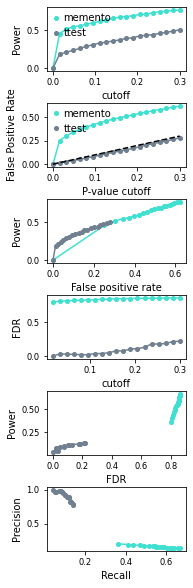

In [77]:
plt.figure(figsize=(2.5, 10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(6, 1, 1)
for method in methods:
    plt.plot(thresholds, tpr_pv_dict[method], '-o', label=method, ms=4)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('Power'); plt.xlabel('P-value cutoff')
plt.xlabel('cutoff')

plt.subplot(6, 1, 2)
for method in methods:
    plt.plot(thresholds, fpr_dict[method], '-o', label=method, ms=4)
plt.plot([0,0.3], [0, 0.3], '--', color='k')

plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('False Positive Rate'); plt.xlabel('P-value cutoff')

plt.subplot(6, 1, 3)
for method in methods:
    plt.plot(fpr_dict[method], np.array(tpr_pv_dict[method]),'-o', label=method, ms=4)
plt.ylabel('Power'); plt.xlabel('False positive rate')

plt.subplot(6, 1, 4)
for method in methods:
    plt.plot(thresholds, fdr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('FDR'); plt.xlabel('FDR cutoff')
plt.xlabel('cutoff')

plt.subplot(6, 1, 5)
for method in methods:
    plt.plot(fdr_dict[method], np.array(tpr_fdr_dict[method]),'-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('Power'); plt.xlabel('FDR')
# plt.xlabel('P-value cutoff')

plt.subplot(6, 1, 6)
for method in methods:
    plt.plot(np.array(tpr_fdr_dict[method]), 1-np.array(fdr_dict[method]),'-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('Precision'); plt.xlabel('Recall')

# plt.savefig('de_comparison.pdf', bbox_inches='tight')

### Compare DE methods - repeated

In [35]:
from pymare import estimators, core

In [36]:
trial = 1

In [37]:
de_sim_adata = sc.read(data_path + 'means/repeated/anndata_{}.h5ad'.format(trial))
de_sim_adata.obs['q'] = 0.05

memento.setup_memento(de_sim_adata, q_column='q', filter_mean_thresh=0.01,trim_percent=0.1, shrinkage=0)
# de_sim_adata.obs['memento_size_factor'] = de_sim_adata.X.sum(axis=1).A1
memento.create_groups(de_sim_adata, label_columns=['condition', 'group'])
memento.compute_1d_moments(de_sim_adata, filter_genes=True)

meta_df = memento.get_groups(de_sim_adata)
meta_df = pd.get_dummies(meta_df, prefix='', prefix_sep='', drop_first=True)

treatment = meta_df[['stim']]
covariate = pd.DataFrame(np.ones((meta_df.shape[0],1)))
# covariate = meta_df[['B', 'C', 'D']]
# covariate = pd.concat([covariate, covariate*treatment.values], axis=1)

means = memento.ht_1d_moments(
    de_sim_adata, 
    treatment=treatment,
    covariate=covariate,
    num_boot=5000, 
    verbose=1,
    num_cpus=14,
    resample_rep=False,
    approx=True)

memento_de_result = memento.get_1d_ht_result(de_sim_adata)
memento_de_result.to_csv(data_path + 'means/stratified/memento.csv', index=False)

im here


[Parallel(n_jobs=14)]: Using backend LokyBackend with 14 concurrent workers.
[Parallel(n_jobs=14)]: Done  22 tasks      | elapsed:    0.4s
[Parallel(n_jobs=14)]: Done 316 tasks      | elapsed:    4.8s
[Parallel(n_jobs=14)]: Done 816 tasks      | elapsed:   11.4s
[Parallel(n_jobs=14)]: Done 1516 tasks      | elapsed:   20.4s
[Parallel(n_jobs=14)]: Done 2416 tasks      | elapsed:   32.2s
[Parallel(n_jobs=14)]: Done 3516 tasks      | elapsed:   46.7s
[Parallel(n_jobs=14)]: Done 4816 tasks      | elapsed:  1.1min
[Parallel(n_jobs=14)]: Done 6084 out of 6084 | elapsed:  1.4min finished


In [38]:
# # datasets = [core.Dataset(y=m, v=v, X=meta_df[['stim']].values, add_intercept=True) for m,v in means]
# results = []

# for m,v in means:
    
#     df = meta_df
#     df['m'] = m
#     df['v'] = v
#     dset = core.Dataset(data=df, y='m', v='v', X=['stim'])
    
#     res = estimators.DerSimonianLaird().fit_dataset(dset).summary().to_df().set_index('name').loc['stim', ['estimate', 'p-value']]
    
#     results.append(res)
    
# memento_results = pd.DataFrame(np.vstack([results]),columns=['coef', 'de_pval'])

# memento_results['gene'] = de_sim_adata.var.index
# memento_results['means'] = [m[0] for m in means]
# memento_results['ses'] = [m[1] for m in means]
# memento_results.to_csv(data_path + 'means/repeated/memento_{}.csv'.format(trial), index=False)

In [39]:
de_norm_adata = sc.read(data_path + 'means/repeated/norm_anndata_{}.h5ad'.format(trial))
result = pd.read_csv(data_path + 'means/repeated/memento_{}.csv'.format(trial)).set_index('gene')
edger = pd.read_csv(data_path + 'means/repeated/edger_{}.csv'.format(trial), index_col=0)

genes = list(set(result.index.tolist()) & set(edger.index))
de_norm_adata = de_norm_adata[:, genes]

result = pd.concat([result.loc[genes], edger.loc[genes]], axis=1)

A_data, B_data = de_norm_adata[de_norm_adata.obs['condition'] == 'ctrl'].X, de_norm_adata[de_norm_adata.obs['condition'] == 'stim'].X
_, result['ttest'] = stats.ttest_ind(A_data, B_data, equal_var=False)
result['mwu'] = np.array([stats.mannwhitneyu(A_data[:, i], B_data[:,i])[1] for i in range(A_data.shape[1])])

result['null'] = de_norm_adata.var['is_null'].values
result['sig'] = ~result['null']
result['memento'] = result['de_pval']
result['edger'] = result['PValue']

In [40]:
result['ttest_fdr'] = memento.util._fdrcorrect(result['ttest'])
result['memento_fdr'] = memento.util._fdrcorrect(result['de_pval'])
result['mwu_fdr'] = memento.util._fdrcorrect(result['mwu'])
result['edger_fdr'] = memento.util._fdrcorrect(result['edger'])

In [41]:
result = result.dropna()

In [42]:
# methods = ['memento_fdr', 'ttest_fdr','edger_fdr']
methods = ['memento', 'ttest','edger', 'mwu']

In [63]:
thresholds = np.linspace(0, 0.3, 20)

tpr_pv_dict = {}
tpr_fdr_dict = {}
precision_pv_dict = {}
precision_fdr_dict = {}
fdr_dict = {}
fpr_dict = {}
for method in methods:
    tpr_pv = []
    tpr_fdr = []
    fpr = []
    fdr = []
    precision_pv = []
    precision_fdr = []

    for thresh in thresholds:
    
        tpr_pv.append((result.query('sig')[method] < thresh).mean())
        tpr_fdr.append((result.query('sig')[method+'_fdr'] < thresh).mean())
        fdr.append(result.query('{} < {}'.format(method+'_fdr', thresh))['null'].mean())
        fpr.append((result.query('null')[method] < thresh).mean())
        
    tpr_pv_dict[method] = tpr_pv
    tpr_fdr_dict[method] = tpr_fdr
    fpr_dict[method] = fpr
    fdr_dict[method] = fdr

Text(0.5, 0, 'Recall')

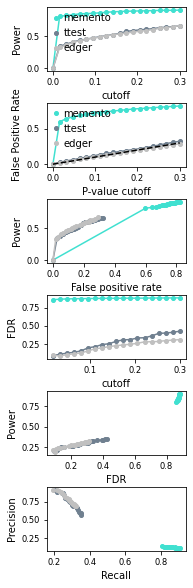

In [64]:
plt.figure(figsize=(2.5, 10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(6, 1, 1)
for method in methods:
    plt.plot(thresholds, tpr_pv_dict[method], '-o', label=method, ms=4)
plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('Power'); plt.xlabel('P-value cutoff')
plt.xlabel('cutoff')

plt.subplot(6, 1, 2)
for method in methods:
    plt.plot(thresholds, fpr_dict[method], '-o', label=method, ms=4)
plt.plot([0,0.3], [0, 0.3], '--', color='k')

plt.legend(frameon=False, loc='upper left', bbox_to_anchor=(0,1.05))
plt.ylabel('False Positive Rate'); plt.xlabel('P-value cutoff')

plt.subplot(6, 1, 3)
for method in methods:
    plt.plot(fpr_dict[method], np.array(tpr_pv_dict[method]),'-o', label=method, ms=4)
plt.ylabel('Power'); plt.xlabel('False positive rate')

plt.subplot(6, 1, 4)
for method in methods:
    plt.plot(thresholds, fdr_dict[method], '-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('FDR'); plt.xlabel('FDR cutoff')
plt.xlabel('cutoff')

plt.subplot(6, 1, 5)
for method in methods:
    plt.plot(fdr_dict[method], np.array(tpr_fdr_dict[method]),'-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('Power'); plt.xlabel('FDR')
# plt.xlabel('P-value cutoff')

plt.subplot(6, 1, 6)
for method in methods:
    plt.plot(np.array(tpr_fdr_dict[method]), 1-np.array(fdr_dict[method]),'-o', label=method, ms=4)
# plt.legend(['memento', 'BASiCS'], frameon=False, loc='center right')
# plt.plot([0,1], [0, 1], '--', color='k')
plt.ylabel('Precision'); plt.xlabel('Recall')

# plt.savefig('de_comparison.pdf', bbox_inches='tight')

In [50]:
print(result.query('edger_fdr < 0.1').shape[0], result.query('edger_fdr < 0.1').null.mean())

77 0.8311688311688312


In [51]:
print(result.query('memento_fdr < 0.1').shape[0], result.query('memento_fdr < 0.1').null.mean())

83 0.40963855421686746


/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg/memento/hypothesis_test.py:210: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg/memento/hypothesis_test.py:210: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg/memento/hypothesis_test.py:210: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg/memento/hypothesis_test.py:210: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg/memento/hypothesis_test.py:210: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.1.0-py3.8.egg/memento/hypothesis_test.py:210: RuntimeWarning: divide by zero encountered in log
/home/ssm-user/Github/scrna-parameter-es

In [117]:
result.query('edger_fdr < 0.1').sig.mean()

0.811965811965812

In [79]:
# plt.figure(figsize=(2.5, 2))
# for col in ['de_pval', 'ttest', 'mwu']:
    
#     fpr, tpr, t = roc_curve(result['sig'], 1-result[col])
#     plt.plot(fpr, tpr, label=col)
    
# plt.legend(['memento', 't-test', 'MWU'])
# plt.xlabel('False positive rate')
# plt.ylabel('True positive rate')
# plt.title('AUC curve (Differential mean)')
# plt.xlim(-0.01, 0.4);
# plt.ylim(-0.01, 0.6)
# plt.plot([0, 0.4], [0, 0.4], '--', color='black')